In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
#from data_loader import load_npy_files, create_tf_dataset  # Import dataset utilities


2025-03-11 20:50:24.087007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 20:50:24.123242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741701024.140264  258144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741701024.145222  258144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 20:50:24.188213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents memory overflow
        print(f"Using GPU: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)


GPU memory growth enabled.


In [4]:

# Load dataset paths
X_train_path = "/media/tairo/Storages/DataSetAnimals/.npy format/X_train.npy"
y_train_path = "/media/tairo/Storages/DataSetAnimals/.npy format/y_train.npy"
X_val_path = "/media/tairo/Storages/DataSetAnimals/.npy format/X_val.npy"
y_val_path = "/media/tairo/Storages/DataSetAnimals/.npy format/y_val.npy"

In [5]:
# Load dataset
X_train = np.load(X_train_path)
y_train = np.load(y_train_path)
X_val = np.load(X_val_path)
y_val = np.load(y_val_path)


In [6]:
# Detect number of classes
class_indices = np.unique(y_train)
num_classes = len(class_indices)

# Create a class mapping (assumes class labels are integers: 0, 1, 2, ...)
class_map = {idx: f"Class_{idx}" for idx in class_indices}  

In [7]:
# Convert labels to one-hot encoding
num_classes = len(np.unique(y_train))  
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [8]:
# Print class information
print(f"Detected {num_classes} classes:", class_map)
print("\nTrain Labels:", np.unique(np.argmax(y_train, axis=1), return_counts=True))
print("Validation Labels:", np.unique(np.argmax(y_val, axis=1), return_counts=True))

Detected 3 classes: {np.int64(0): 'Class_0', np.int64(1): 'Class_1', np.int64(2): 'Class_2'}

Train Labels: (array([0, 1, 2]), array([700, 700, 700]))
Validation Labels: (array([0, 1, 2]), array([200, 200, 200]))


In [9]:

# Define batch size (reduce to fit in GPU memory)
BATCH_SIZE = 4  # Reduce from 32 to avoid GPU memory overflow

# Convert NumPy arrays into TensorFlow dataset (streaming)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1741701028.470847  258144 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1922 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
def build_vgg16(input_shape=(224, 224, 3), num_classes=4, reg_strength=0.0005):
    # Load VGG16 Pretrained Model (Without Fully Connected Top Layers)
    base_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
    # Freeze base model layers initially
    base_model.trainable = False  
    
    # Extract features from VGG16
    x = base_model.output  
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling

    # Fully Connected Layers (64 → 32 → 16)
    x = Dense(32, kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(16, kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(8, kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Final Classification Layer
    outputs = Dense(num_classes, activation='softmax', dtype="float32", kernel_regularizer=l2(reg_strength))(x)

    # Build Model
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [11]:
# Build the VGG16 model
model = build_vgg16(input_shape=(224, 224, 3), num_classes=num_classes)


In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [13]:
# Define callbacks
BEST_MODEL_PATH = "VGG16(1).keras"

checkpoint = ModelCheckpoint(
    BEST_MODEL_PATH, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="min", verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True, mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-7
)

In [14]:
with tf.device('/GPU:0'):  # Forces GPU usage
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=200,  # Increase if needed
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

Epoch 1/200


I0000 00:00:1741701032.769793  258384 service.cc:148] XLA service 0x7fdd7c015e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741701032.769811  258384 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-03-11 20:50:32.818854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741701033.134774  258384 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-11 20:50:34.455726: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 114.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-11 20:50:34.475604: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0

  5/525 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.4508 - loss: 1.1367

I0000 00:00:1741701038.694162  258384 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3828 - loss: 1.2188
Epoch 1: val_loss improved from inf to 0.85509, saving model to VGG16(1).keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.3829 - loss: 1.2187 - val_accuracy: 0.8383 - val_loss: 0.8551 - learning_rate: 0.0010
Epoch 2/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5762 - loss: 0.9632
Epoch 2: val_loss improved from 0.85509 to 0.56103, saving model to VGG16(1).keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.5762 - loss: 0.9632 - val_accuracy: 0.9300 - val_loss: 0.5610 - learning_rate: 0.0010
Epoch 3/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6539 - loss: 0.8979
Epoch 3: val_loss improved from 0.56103 to 0.46704, saving model to VGG16(1).keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.6540 - loss: 0.8978 - val_accuracy: 0.9500 - val_loss: 0.4670 - learning_rate: 0.0010
Epoch 4/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6773 -

In [15]:
# Load the best saved model
best_model = load_model(BEST_MODEL_PATH)

In [16]:
# Evaluate on validation set
val_loss, val_acc = best_model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9911 - loss: 0.2120
Validation Accuracy: 98.50%


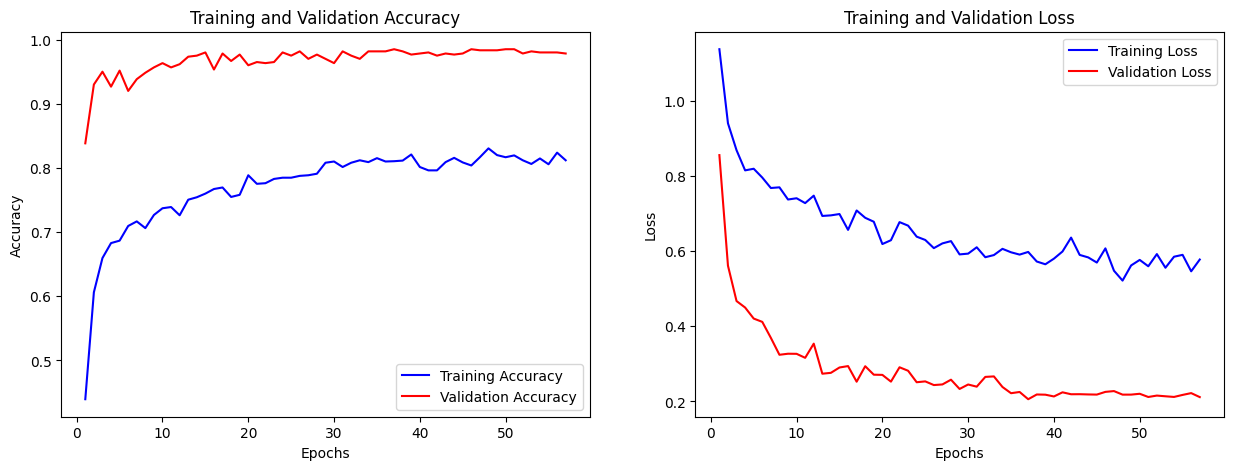

In [17]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
axs[0].plot(epochs, train_acc, 'b', label='Training Accuracy')
axs[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot Loss
axs[1].plot(epochs, train_loss, 'b', label='Training Loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.show()